In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
river_dl = np.load("../../../Downloads/prepped2.npz", allow_pickle = True)

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

# maintains relationships, just changes how they're organized
reorder_spatially = np.random.choice(455, 455, replace=False)

adj_matrix = river_dl['dist_matrix']
batch_size = adj_matrix.shape[0]

x.shape, y.shape, adj_matrix.shape

(torch.Size([455, 365, 16]), torch.Size([455, 365, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(16, 20, adj_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

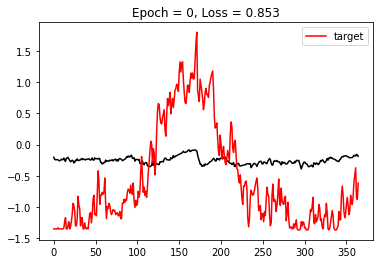

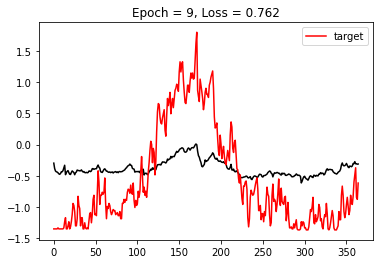

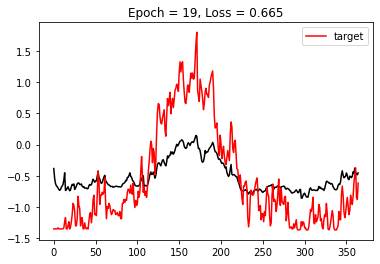

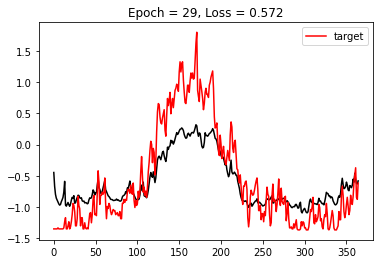

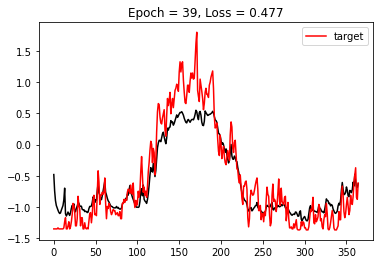

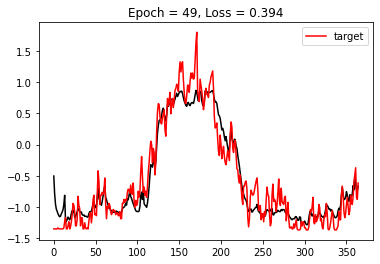

In [6]:
epochs = 50

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

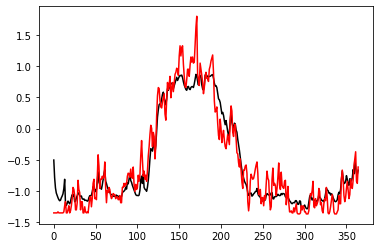

In [7]:
plt.plot(out.detach()[1], color = 'black')
plt.plot(y[1], color = 'red', label = 'target')

# Define a manual/custom implementation of Integrated Gradients

In [8]:
def integrated_gradients(x, y, model, n_steps, baseline_x, temporal_focus=None, spatial_focus=None):
    x.requires_grad = True
    x_diff = x - baseline_x

    for k in range(1, n_steps):
        numerator_scale = k/n_steps
        curr_x = baseline_x + numerator_scale*x_diff
        y = model(curr_x)
        if temporal_focus == None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus == None and spatial_focus != None:
            gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
        elif temporal_focus != None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        else:
            gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))
            
        if k == 1:
            integrated_gradients = gradients
        else:
            integrated_gradients = integrated_gradients + gradients

    integrated_gradients = x_diff.detach().numpy()*integrated_gradients[0].detach().numpy()
    return(integrated_gradients)

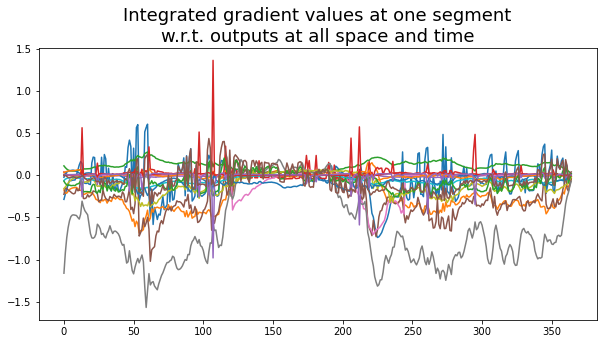

In [9]:
IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x))

plt.figure(figsize = (10, 5))
for i in range(16):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

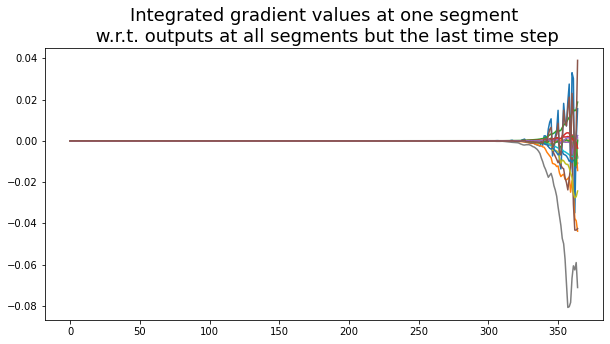

In [10]:
IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x), temporal_focus = -1)

plt.figure(figsize = (10, 5))
for i in range(16):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\n w.r.t. outputs at all segments but the last time step',
          fontsize = 18);

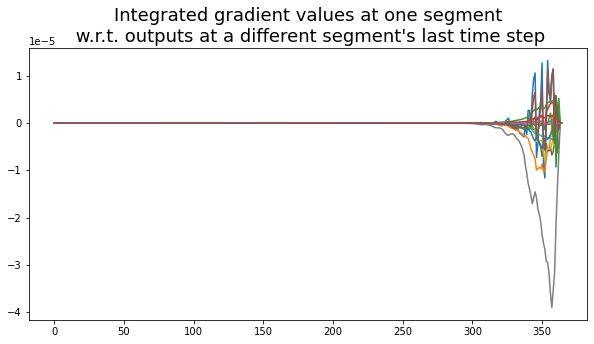

In [11]:
IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x), temporal_focus = -1, spatial_focus = -1)

plt.figure(figsize = (10, 5))
for i in range(16):
    plt.plot(IG_vals[0, :, i])
plt.title("Integrated gradient values at one segment\n w.r.t. outputs at a different segment's last time step",
          fontsize = 18);

# Apply XAI and visualize - can we trust IG temporally?

When looking at what's important for the last time step's prediction, it appears that anything before the last 45 values don't matter. Let's do an experiment where we scramble those supposedly irrelevant values and see how it impacts predictions

In [12]:
IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x), temporal_focus = -1)

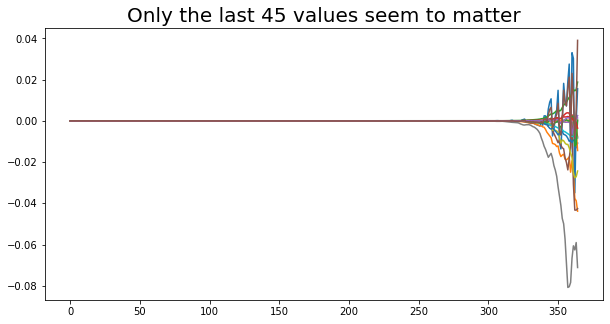

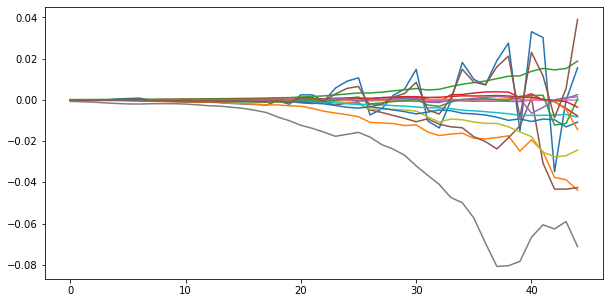

In [13]:
plt.figure(figsize = (10, 5))
plt.plot(IG_vals[0, :, :])
plt.title('Only the last 45 values seem to matter', fontsize = 20)
plt.pause(0.001)
plt.figure(figsize = (10, 5))
plt.plot(IG_vals[0, -45:, :]);

In [14]:
def compare_temporally_altered(first_n_days):
    y_hat_original = model(x)

    # replace first n out of 365 days with random values
    # and see how results change
    x_hypothesis = x.detach().clone()
    x_hypothesis[:, :first_n_days] = torch.rand_like(x[:, :first_n_days])
    y_hat_hypothesis = model(x_hypothesis)

    fig, ax = plt.subplots(3, 2, figsize = (12, 9))

    ax[0,0].plot(x[0].detach(), color = 'black', alpha = 0.1)
    ax[0,0].set_ylim(-3, 5)
    ax[0,1].plot(x_hypothesis[0], color = 'black', alpha = 0.1)
    ax[0,1].set_ylim(-3, 5)
    ax[1,0].plot(y_hat_original[0].detach())
    ax[1,0].set_ylim(-1.5, 1.5)
    ax[1,1].plot(y_hat_hypothesis[0].detach())
    ax[1,1].set_ylim(-1.5, 1.5)
    ax[2,0].plot(y_hat_original[0, :].detach())
    ax[2,0].plot(y_hat_hypothesis[0, :].detach())
    ax[2,1].plot(y_hat_original[0, -60:].detach())
    ax[2,1].plot(y_hat_hypothesis[0, -60:].detach());

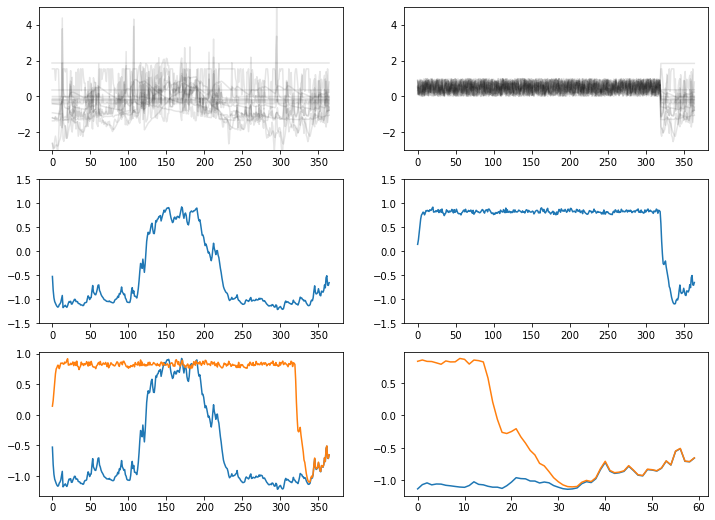

In [15]:
compare_temporally_altered(365-45)

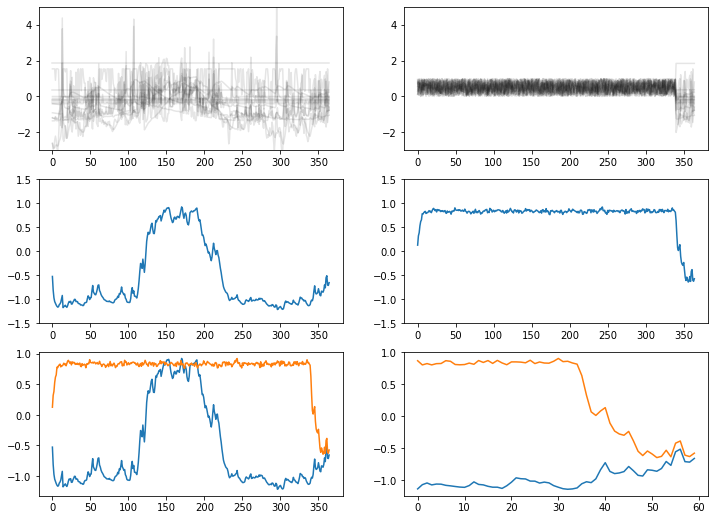

In [16]:
compare_temporally_altered(365-25)

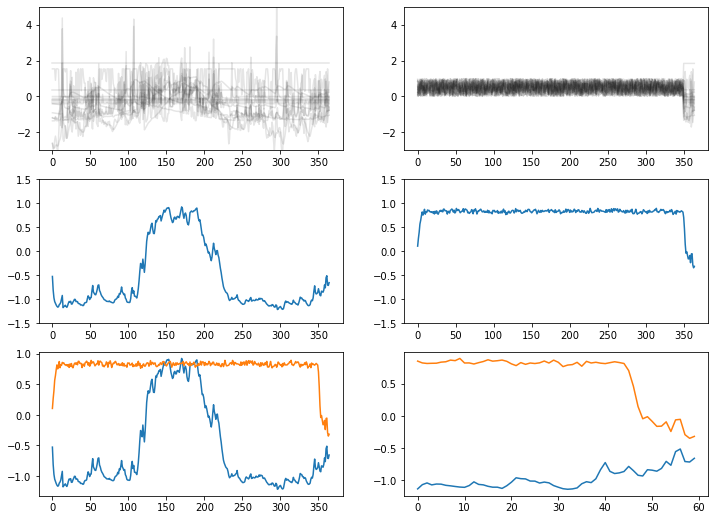

In [17]:
compare_temporally_altered(365-15)

The evidence appears to suggest that we can trust how IG explains importance temporally

# Apply XAI and visualize - can we trust IG spatially?

Similar experiment to the above, but seeing if we can trust what neighboring streams are identified as important

In [18]:
def compare_spatially_altered(seg_of_interest, important_segments, unimportant_segments):
    y_hat_original = model(x)

    x_hypothesis1 = x.detach().clone()
    for s in important_segments:
        x_hypothesis1[s] = torch.rand_like(x[s])
    y_hat_hypothesis1 = model(x_hypothesis1)
    
    x_hypothesis2 = x.detach().clone()
    for s in unimportant_segments:
        x_hypothesis2[s] = torch.rand_like(x[s])
    y_hat_hypothesis2 = model(x_hypothesis2)

    fig, ax = plt.subplots(5, figsize = (10, 30))

    for seg in important_segments:
        ax[0].plot(x[seg].detach(), color = 'black', alpha = 0.05)
        ax[1].plot(x_hypothesis1[seg], color = 'black', alpha = 0.1)
        ax[1].set_title('Changed segment variable values | important')
        
    for seg in unimportant_segments:
        ax[0].plot(x[seg].detach(), color = 'black', alpha = 0.05)
        ax[0].set_title('Unchanged segment variable')
        ax[2].plot(x_hypothesis2[seg], color = 'black', alpha = 0.1)
        ax[2].set_title('Changed segment variable values | unimportant')
    
    ax[3].set_title('Predictions under different scenarios')
    ax[3].plot(y_hat_original[seg_of_interest, :].detach(),
               label = 'Original')
    ax[3].plot(y_hat_hypothesis1[seg_of_interest, :].detach(),
               label = 'Important segments changed',
               linestyle = '--')
    ax[3].plot(y_hat_hypothesis2[seg_of_interest, :].detach(),
               label = 'Unimportant segments changed',
               linestyle = '--')
    ax[3].legend()
    
    ax[4].set_title('Difference in predictions')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis1[seg_of_interest, :].detach(),
                 label = 'Important segments changed')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis2[seg_of_interest, :].detach(),
                 label = 'Unimportant segments changed')
    ax[4].legend()

In [19]:
spatial_focus = np.random.choice(455)

IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x), temporal_focus = -1, spatial_focus = spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[-5:]

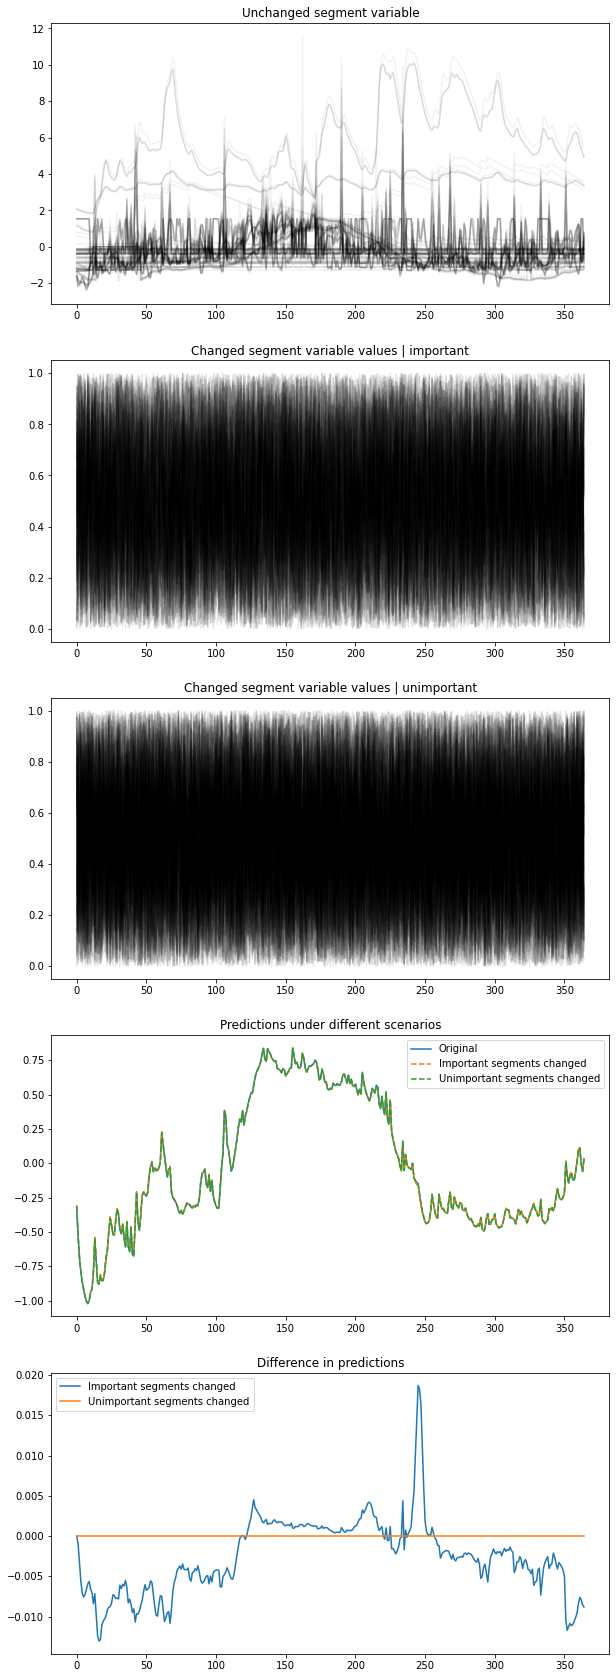

In [20]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

### A slightly more obvious difference in predictions

Spatial information doesn't seem to play a huge role, so hand-picking a more sensitive segment helps show the difference

In [21]:
spatial_focus = -1

IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x), temporal_focus = -1, spatial_focus = spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[-5:]

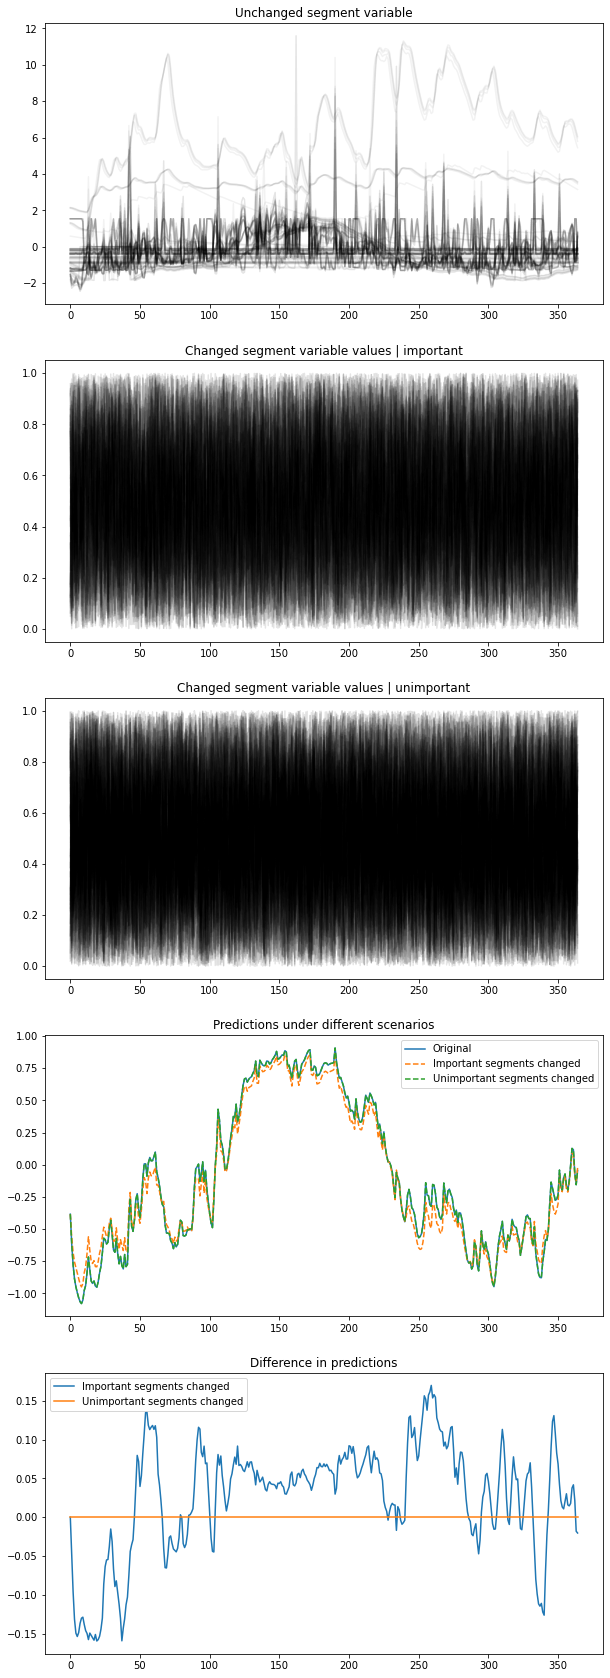

In [22]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

The evidence appears to suggest that we can trust how IG explains importance spatially